In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold
import warnings
warnings.simplefilter(action='ignore')
sns.set()
plt.style.use("ggplot")
%matplotlib inline


In [30]:
# read the dataset from dir
df = pd.read_csv("diabetes.csv")

In [31]:
df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']] = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']].replace(0, np.NaN)

In [32]:
#median
def median_target(var):   
    temp = df[df[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

In [33]:
columns = df.columns
columns = columns.drop("Outcome")
for i in columns:
    median_target(i)
    df.loc[(df['Outcome'] == 0 ) & (df[i].isnull()), i] = median_target(i)[i][0]
    df.loc[(df['Outcome'] == 1 ) & (df[i].isnull()), i] = median_target(i)[i][1]

In [34]:
# Outlier Detection
# IQR+Q1
# 50%
# 24.65->25%+50%
# 24.65->25%
for feature in df:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3-Q1
    lower = Q1-1.5*IQR
    upper = Q3+1.5*IQR
    if df[(df[feature]>upper)].any(axis=None):
        print(feature, "yes")
    else:
        print(feature, "no")

Pregnancies yes
Glucose no
BloodPressure yes
SkinThickness yes
Insulin yes
BMI yes
DiabetesPedigreeFunction yes
Age yes
Outcome no


In [35]:
Q1 = df.Insulin.quantile(0.25)
Q3 = df.Insulin.quantile(0.75)
IQR = Q3-Q1
lower = Q1-1.5*IQR
upper = Q3+1.5*IQR
df.loc[df['Insulin']>upper, "Insulin"] = upper

In [36]:
# LOF
# local outlier factor
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=10)
lof.fit_predict(df)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1

In [37]:
df_scores = lof.negative_outlier_factor_
np.sort(df_scores)[0:20]

array([-3.06509976, -2.38250393, -2.15557018, -2.11501347, -2.08356175,
       -1.95386655, -1.83559384, -1.74974237, -1.7330214 , -1.71017168,
       -1.70215105, -1.68722889, -1.64294601, -1.64180205, -1.61181746,
       -1.61067772, -1.60925053, -1.60214364, -1.59998552, -1.58761193])

In [38]:
thresold = np.sort(df_scores)[7]

In [39]:
thresold

-1.7497423670960557

In [40]:
outlier = df_scores>thresold

In [41]:
df = df[outlier]

In [42]:
# Feature Enginnering
NewBMI = pd.Series(["Underweight","Normal", "Overweight","Obesity 1", "Obesity 2", "Obesity 3"], dtype = "category")

In [43]:
df['NewBMI'] = None  # Initialize column

# Assign categories based on BMI ranges
df.loc[df['BMI'] > 39.9, 'NewBMI'] = 'Obesity 3'
df.loc[(df['BMI'] > 34.9) & (df['BMI'] <= 39.9), 'NewBMI'] = 'Obesity 2'
df.loc[(df['BMI'] > 29.9) & (df['BMI'] <= 34.9), 'NewBMI'] = 'Obesity 1'
df.loc[(df['BMI'] >= 25) & (df['BMI'] <= 29.9), 'NewBMI'] = 'Overweight'
df.loc[(df['BMI'] >= 18.5) & (df['BMI'] < 25), 'NewBMI'] = 'Normal'
df.loc[df['BMI'] < 18.5, 'NewBMI'] = 'Underweight'

# Convert to categorical with specified order
category_order = ['Underweight', 'Normal', 'Overweight', 'Obesity 1', 'Obesity 2', 'Obesity 3']
df['NewBMI'] = pd.Categorical(df['NewBMI'], categories=category_order, ordered=True)


In [44]:
# if insulin>=16 & insuline<=166->normal
def set_insuline(row):
    if row["Insulin"]>=16 and row["Insulin"]<=166:
        return "Normal"
    else:
        return "Abnormal"

In [45]:
df = df.assign(NewInsulinScore=df.apply(set_insuline, axis=1))

In [46]:
# Initialize NewGlucose categories (reversed order)
NewGlucose = pd.Series(["Secret", "Overweight", "Normal", "Low"], dtype="category")

# Assign categories based on Glucose ranges (largest to smallest)
df["NewGlucose"] = None  # Initialize the column

# Start with the largest range and work downwards
df.loc[df["Glucose"] > 126, "NewGlucose"] = "Secret"  # Greater than 126
df.loc[(df["Glucose"] > 99) & (df["Glucose"] <= 126), "NewGlucose"] = "Overweight"
df.loc[(df["Glucose"] > 70) & (df["Glucose"] <= 99), "NewGlucose"] = "Normal"
df.loc[df["Glucose"] <= 70, "NewGlucose"] = "Low"  # Less than or equal to 70

# Convert NewGlucose to categorical with the correct order
category_order = ["Low", "Normal", "Overweight", "Secret"]
df["NewGlucose"] = pd.Categorical(df["NewGlucose"], categories=category_order, ordered=True)


In [47]:
# One hot encoding
df = pd.get_dummies(df, columns = ["NewBMI", "NewInsulinScore", "NewGlucose"], drop_first=True)

In [48]:
categorical_df = df[['NewBMI_Obesity 1',
       'NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight',
        'NewInsulinScore_Normal','NewBMI_Normal',
       'NewGlucose_Normal', 'NewGlucose_Overweight', 'NewGlucose_Secret']]

In [49]:
cols = X.columns
index = X.index

In [50]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21
4,5.0,137.0,40.0,35.0,168.0,43.1,2.288,33


In [51]:
X = pd.concat([X, categorical_df], axis=1)

In [52]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewInsulinScore_Normal,NewBMI_Normal,NewGlucose_Normal,NewGlucose_Overweight,NewGlucose_Secret
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50,True,False,False,False,False,False,False,False,True
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31,False,False,False,True,True,False,True,False,False
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32,False,False,False,False,False,True,False,False,True
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21,False,False,False,True,True,False,True,False,False
4,5.0,137.0,40.0,35.0,168.0,43.1,2.288,33,False,False,True,False,False,False,False,False,True


In [53]:
X_train, X_test, y_train , y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [54]:
from sklearn.preprocessing import RobustScaler

# Assuming X_train and X_test are your datasets
scaler = RobustScaler()

# Extract the first 8 columns for scaling
X_train_first_8_cols = X_train.iloc[:, :8]
X_test_first_8_cols = X_test.iloc[:, :8]

# Fit the scaler on the training data and transform both train and test sets
X_train_scaled_first_8_cols = scaler.fit_transform(X_train_first_8_cols)
X_test_scaled_first_8_cols = scaler.transform(X_test_first_8_cols)

# Replace the first 8 columns with the scaled data
X_train.iloc[:, :8] = X_train_scaled_first_8_cols
X_test.iloc[:, :8] = X_test_scaled_first_8_cols

# X_train and X_test now have the first 8 columns scaled while others remain unchanged.


In [59]:
from sklearn.preprocessing import StandardScaler

# Assuming X_train and X_test are your datasets
scaler = StandardScaler()

# Extract the first 8 columns for scaling
X_train_first_8_col = X_train.iloc[:, :8]
X_test_first_8_col = X_test.iloc[:, :8]

# Fit the scaler on the training data and transform both train and test sets
X_train_scaled_first_8_col = scaler.fit_transform(X_train_first_8_col)
X_test_scaled_first_8_col = scaler.transform(X_test_first_8_col)

# Replace the first 8 columns with the scaled data
X_train.iloc[:, :8] = X_train_scaled_first_8_col
X_test.iloc[:, :8] = X_test_scaled_first_8_col

# X_train and X_test now have the first 8 columns scaled while others remain unchanged.


In [61]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [62]:
y_pred = log_reg.predict(X_test)

In [63]:
accuracy_score(y_train, log_reg.predict(X_train))

0.8519736842105263

In [64]:
log_reg_acc = accuracy_score(y_test, log_reg.predict(X_test))

In [65]:
log_reg_acc

0.875

In [66]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(accuracy_score(y_train, knn.predict(X_train)))
knn_acc = accuracy_score(y_test, knn.predict(X_test))
print(accuracy_score(y_test, knn.predict(X_test)))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.881578947368421
0.875
[[88 10]
 [ 9 45]]
              precision    recall  f1-score   support

           0       0.91      0.90      0.90        98
           1       0.82      0.83      0.83        54

    accuracy                           0.88       152
   macro avg       0.86      0.87      0.86       152
weighted avg       0.88      0.88      0.88       152



In [67]:
# SVM
svc = SVC(probability=True)
parameter = {
    "gamma":[0.0001, 0.001, 0.01, 0.1],
    'C': [0.01, 0.05,0.5, 0.01, 1, 10, 15, 20]
}
grid_search = GridSearchCV(svc, parameter)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.01, 0.05, 0.5, 0.01, 1, 10, 15, 20],
                         'gamma': [0.0001, 0.001, 0.01, 0.1]})

In [68]:
# best_parameter
grid_search.best_params_

{'C': 0.5, 'gamma': 0.1}

In [69]:
grid_search.best_score_

0.8684731066251186

In [70]:
y_pred = grid_search.predict(X_test)
print(accuracy_score(y_train, grid_search.predict(X_train)))
svc_acc = accuracy_score(y_test, grid_search.predict(X_test))
print(svc_acc)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8980263157894737
0.8881578947368421
[[90  8]
 [ 9 45]]
              precision    recall  f1-score   support

           0       0.91      0.92      0.91        98
           1       0.85      0.83      0.84        54

    accuracy                           0.89       152
   macro avg       0.88      0.88      0.88       152
weighted avg       0.89      0.89      0.89       152



In [92]:
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)
y_pred = DT.predict(X_test)
print(accuracy_score(y_train, DT.predict(X_train)))

print(accuracy_score(y_test, DT.predict(X_test)))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

1.0
0.8552631578947368
[[84 14]
 [ 8 46]]
              precision    recall  f1-score   support

           0       0.91      0.86      0.88        98
           1       0.77      0.85      0.81        54

    accuracy                           0.86       152
   macro avg       0.84      0.85      0.85       152
weighted avg       0.86      0.86      0.86       152



In [93]:
grid_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7],
    'splitter': ['best', 'random'],
    'min_samples_leaf': [1, 2,3,5,7],
    'min_samples_split': [1,2,3,5,7],
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': ['balanced', None]  # For imbalanced data
}

grid_search_dts = GridSearchCV(DT, grid_params, cv=5, n_jobs=-1, verbose=1)
grid_search_dts.fit(X_train, y_train)


Fitting 5 folds for each of 1800 candidates, totalling 9000 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 5, 7],
                         'min_samples_split': [1, 2, 3, 5, 7],
                         'splitter': ['best', 'random']},
             verbose=1)

In [94]:
#DT = grid_search_dts.best_estimator_
y_pred = grid_search_dts.predict(X_test)
print(accuracy_score(y_train, grid_search_dts.predict(X_train)))
dt_accr = accuracy_score(y_test, y_pred)
print(dt_accr)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9013157894736842
0.881578947368421
[[87 11]
 [ 7 47]]
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        98
           1       0.81      0.87      0.84        54

    accuracy                           0.88       152
   macro avg       0.87      0.88      0.87       152
weighted avg       0.88      0.88      0.88       152



In [107]:
rand_clf = RandomForestClassifier(criterion = 'entropy', max_depth = 15, max_features = 0.75, min_samples_leaf = 2, min_samples_split = 3, n_estimators = 130)
rand_clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=15, max_features=0.75,
                       min_samples_leaf=2, min_samples_split=3,
                       n_estimators=130)

In [108]:
y_pred = rand_clf.predict(X_test)

In [109]:
print(accuracy_score(y_train, rand_clf.predict(X_train)))
rand_acc = accuracy_score(y_test, y_pred)
print(rand_acc)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9917763157894737
0.8947368421052632
[[88 10]
 [ 6 48]]
              precision    recall  f1-score   support

           0       0.94      0.90      0.92        98
           1       0.83      0.89      0.86        54

    accuracy                           0.89       152
   macro avg       0.88      0.89      0.89       152
weighted avg       0.90      0.89      0.90       152



In [103]:
gbc = GradientBoostingClassifier()

parameters = {
    'loss': ['deviance', 'exponential'],
    'learning_rate': [0.001, 0.1, 1, 10],
    'n_estimators': [100, 150, 180, 200]
}

grid_search_gbc = GridSearchCV(gbc, parameters, cv = 10, n_jobs = -1, verbose = 1)
grid_search_gbc.fit(X_train, y_train)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


GridSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.1, 1, 10],
                         'loss': ['deviance', 'exponential'],
                         'n_estimators': [100, 150, 180, 200]},
             verbose=1)

In [104]:
grid_search_gbc.best_params_

{'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}

In [105]:
gbc = GradientBoostingClassifier(learning_rate = 0.1, loss = 'exponential', n_estimators = 100)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(loss='exponential')

In [106]:
gbc =grid_search_gbc.best_estimator_
y_pred = gbc.predict(X_test)
print(accuracy_score(y_train, gbc.predict(X_train)))
gbc_acc = accuracy_score(y_test, y_pred)
print(gbc_acc)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9720394736842105
0.9144736842105263
[[92  6]
 [ 7 47]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93        98
           1       0.89      0.87      0.88        54

    accuracy                           0.91       152
   macro avg       0.91      0.90      0.91       152
weighted avg       0.91      0.91      0.91       152



In [96]:
from xgboost import XGBClassifier 
xgb = XGBClassifier(objective = 'binary:logistic', learning_rate = 0.01, max_depth = 10, n_estimators = 180)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [97]:
y_pred = xgb.predict(X_test)
print(accuracy_score(y_train, xgb.predict(X_train)))
xgb_acc = accuracy_score(y_test, y_pred)
print(xgb_acc)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9736842105263158
0.875
[[88 10]
 [ 9 45]]
              precision    recall  f1-score   support

           0       0.91      0.90      0.90        98
           1       0.82      0.83      0.83        54

    accuracy                           0.88       152
   macro avg       0.86      0.87      0.86       152
weighted avg       0.88      0.88      0.88       152



In [110]:
# Model Comparison
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN', 'SVM', 'Decision Tree Classifier', 'Random Forest Classifier', 'Gradient Boosting Classifier', 'XgBoost'],
    'Score': [100*round(log_reg_acc,4), 100*round(knn_acc,4), 100*round(svc_acc,4), 100*round(dt_accr,4), 100*round(rand_acc,4), 
              100*round(gbc_acc,4), 100*round(xgb_acc,4)]
})
models.sort_values(by = 'Score', ascending = False)

,Model,Score
5,Gradient Boosting Classifier,91.45
4,Random Forest Classifier,89.47
2,SVM,88.82
3,Decision Tree Classifier,88.16
0,Logistic Regression,87.50
1,KNN,87.50
6,XgBoost,87.50


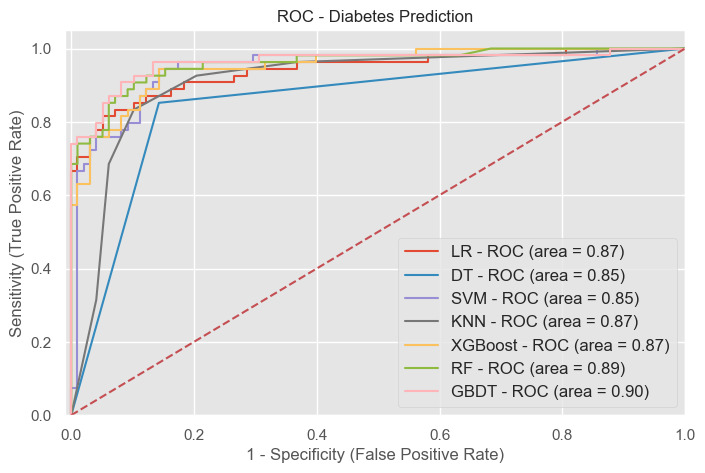

In [111]:
from sklearn import metrics
plt.figure(figsize=(8,5))
models = [
{
    'label': 'LR',
    'model': log_reg,
},
{
    'label': 'DT',
    'model': DT,
},
{
    'label': 'SVM',
    'model': svc,
},
{
    'label': 'KNN',
    'model': knn,
},
{
    'label': 'XGBoost',
    'model': xgb,
},
{
    'label': 'RF',
    'model': rand_clf,
},
{
    'label': 'GBDT',
    'model': gbc,
}
]
for m in models:
    model = m['model'] 
    model.fit(X_train, y_train) 
    y_pred=model.predict(X_test) 
    fpr1, tpr1, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
    plt.plot(fpr1, tpr1, label='%s - ROC (area = %0.2f)' % (m['label'], auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=12)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize=12)
plt.title('ROC - Diabetes Prediction', fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.savefig("roc_diabetes.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()

[87.5, 88.16000000000001, 88.82, 87.5, 87.5, 89.47, 91.45]
[87.4, 85.96000000000001, 84.71, 86.56, 86.56, 89.85, 90.46]


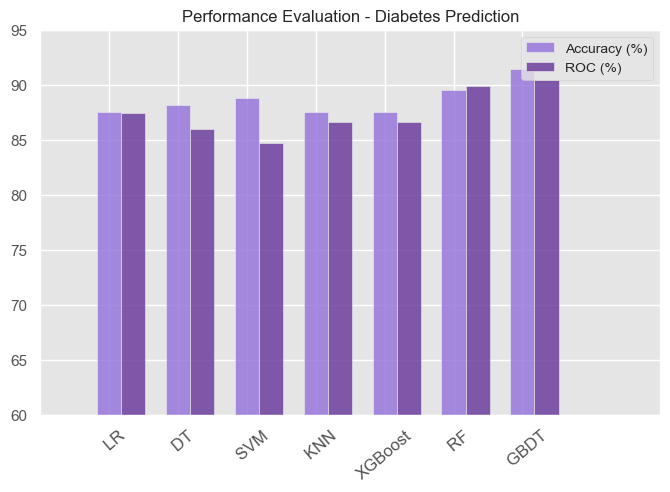

In [112]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
models = [
{
    'label': 'LR',
    'model': log_reg,
},
{
    'label': 'DT',
    'model': DT,
},
{
    'label': 'SVM',
    'model': svc,
},
{
    'label': 'KNN',
    'model': knn,
},
{
    'label': 'XGBoost',
    'model': xgb,
},
{
    'label': 'RF',
    'model': rand_clf,
},
{
    'label': 'GBDT',
    'model': gbc,
}
]

means_roc = []
means_accuracy = [100*round(log_reg_acc,4), 100*round(dt_accr,4), 100*round(svc_acc,4), 100*round(knn_acc,4), 100*round(xgb_acc,4), 
                  100*round(rand_acc,4), 100*round(gbc_acc,4)]

for m in models:
    model = m['model'] 
    model.fit(X_train, y_train) 
    y_pred=model.predict(X_test) 
    fpr1, tpr1, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
    auc = 100*round(auc,4)
    means_roc.append(auc)

print(means_accuracy)
print(means_roc)

# data to plot
n_groups = 7
means_accuracy = tuple(means_accuracy)
means_roc = tuple(means_roc)

# create plot
fig, ax = plt.subplots(figsize=(8,5))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_accuracy, bar_width,
alpha=opacity,
color='mediumpurple',
label='Accuracy (%)')

rects2 = plt.bar(index + bar_width, means_roc, bar_width,
alpha=opacity,
color='rebeccapurple',
label='ROC (%)')

plt.xlim([-1, 8])
plt.ylim([60, 95])

plt.title('Performance Evaluation - Diabetes Prediction', fontsize=12)
plt.xticks(index, ('   LR', '   DT', '   SVM', '   KNN', 'XGBoost' , '   RF', '   GBDT'), rotation=40, ha='center', fontsize=12)
plt.legend(loc="upper right", fontsize=10)
plt.savefig("PE_diabetes.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
import pickle

# Assuming 'gbc' is your trained model
with open("diabetes.pickle", 'wb') as f:
    pickle.dump(gbc, f)


In [ ]:
import json

# Assuming 'X' is your DataFrame with columns used for training
columns = {
    'data_columns': [col for col in X.columns]  # Lowercase column names
}

# Save to JSON file
with open("column_names.json", "w") as f:
    json.dump(columns, f)


In [ ]:
import joblib

joblib.dump(transformer, "robust_scaler.pkl")

joblib.dump(scaler, "standard_scaler.pkl")
